In [18]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist  # Data
from keras.layers import Conv2D, Flatten, MaxPooling2D
from PIL import Image
from tensorflow import keras
from tensorflow.keras import activations, optimizers
from tensorflow.keras.utils import plot_model

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # mac

seed = 0
np.random.seed(seed)  # fix random seed
tf.random.set_seed(seed)

### Exercise 12.1

By keeping fixed all the other parameters, try to use at least two other optimizers, different from SGD. <span style="color:red">Watch to accuracy and loss for training and validation data and comment on the performances</span>.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. 

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

# 12.1 Optimizing optimizers for DNN

### Load Data

In [19]:
# input image dimensions
img_rows, img_cols = 28, 28  # number of pixels
# output
num_classes = 10  # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print()
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "testing samples")

X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows * img_cols)

# cast floats to single precision
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

print()
print("X_train reshape:", X_train.shape)
print("Y_train reshape:", Y_train.shape)

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

index = 40
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
print("an example of a data point with label", Y_train[index], "before to_categorical ...")
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print("... and with label", Y_train[index], "after to_categorical")
print()
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 training samples
10000 testing samples

X_train reshape: (60000, 784)
Y_train reshape: (60000,)
an example of a data point with label 1 before to_categorical ...
... and with label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


an example of a data point with label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


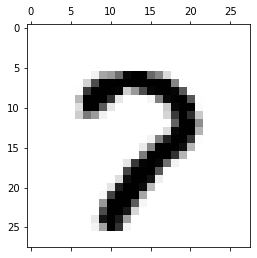

In [23]:
# look at an example of data point
index = np.random.randint(0, 60000 - 1)
print("an example of a data point with label", Y_train[index])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[index, :].reshape(28, 28), cmap="binary")
plt.show()

### Create and Compile

In [24]:
from keras.layers import Dense, Dropout
from keras.models import Sequential


def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400, input_shape=(img_rows * img_cols,), activation="relu"))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation="relu"))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation="softmax"))

    print("Model architecture created successfully!")

    return model

In [25]:
def compile_DNN(OPT):  # Variable optimizer
    # create the model
    model = create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=OPT, metrics=["acc"])

    print("Model compiled successfully and ready to be trained.")

    return model

### Optimizers
- SGD : Mini-batches to update gradient, subject to oscillation around local minima
- Adagrad : Adaptive learning rate for each parameter, good for sparse datasets (some features rarer than others), subject to decaying global learning rate
- Adadelta : Extension of adagrad that seeks to reduce its aggressively decaying learning rates
- RMSprop : Same goal as Adadelta, exponentially decaying average of past gradients
- Adam : Adaptive momentum estimation, behaves like a ball with friction (RMSprop + momentum)
- Adamax : Similar to adam
- Nadam : Adam plus nesterov accelerated momentum (momentum at a future position)

In [26]:
# training parameters
batch_size = 32
N_epochs = 10

### Stochastic Gradient Descent

In [27]:
# create the deep neural net
model_SGD = compile_DNN(optimizers.SGD())

# train DNN and store training info in history
history_SGD = model_SGD.fit(
    X_train, Y_train, batch_size=batch_size, epochs=N_epochs, verbose=1, validation_data=(X_test, Y_test)
)

Model architecture created successfully!
Model compiled successfully and ready to be trained.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 185us/step - loss: 0.7679 - acc: 0.7727 - val_loss: 0.3251 - val_acc: 0.9131
Epoch 2/10
60000/60000 [==============================] - 11s 183us/step - loss: 0.3939 - acc: 0.8883 - val_loss: 0.2419 - val_acc: 0.9314
Epoch 3/10
60000/60000 [==============================] - 14s 226us/step - loss: 0.3161 - acc: 0.9105 - val_loss: 0.2052 - val_acc: 0.9388
Epoch 4/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2705 - acc: 0.9239 - val_loss: 0.1791 - val_acc: 0.9462
Epoch 5/10
60000/60000 [==============================] - 10s 173us/step - loss: 0.2418 - acc: 0.9315 - val_loss: 0.1605 - val_acc: 0.9518
Epoch 6/10
60000/60000 [==============================] - 9s 148us/step - loss: 0.2135 - acc: 0.9408 - val_loss: 0.1444 - val_acc: 0.9545
Epoch 7/10
60000/60000 

### Adagrad

**Comment.** On my machine, default SGD takes about 150us/step. Default Adagrad takes about 290us/step. 

In [28]:
# create the deep neural net
model_Adagrad = compile_DNN(optimizers.Adagrad())

# train DNN and store training info in history
history_Adagrad = model_Adagrad.fit(
    X_train, Y_train, batch_size=batch_size, epochs=N_epochs, verbose=1, validation_data=(X_test, Y_test)
)

Model architecture created successfully!
Model compiled successfully and ready to be trained.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 298us/step - loss: 1.3033 - acc: 0.6133 - val_loss: 0.6290 - val_acc: 0.8665
Epoch 2/10
60000/60000 [==============================] - 17s 275us/step - loss: 0.7029 - acc: 0.7991 - val_loss: 0.4491 - val_acc: 0.8895
Epoch 3/10
60000/60000 [==============================] - 16s 261us/step - loss: 0.5798 - acc: 0.8339 - val_loss: 0.3845 - val_acc: 0.8991
Epoch 4/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.5155 - acc: 0.8531 - val_loss: 0.3490 - val_acc: 0.9060
Epoch 5/10
60000/60000 [==============================] - 19s 319us/step - loss: 0.4779 - acc: 0.8660 - val_loss: 0.3247 - val_acc: 0.9114
Epoch 6/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.4473 - acc: 0.8742 - val_loss: 0.3068 - val_acc: 0.9160
Epoch 7/10
60000/60000

In [59]:
# TO SAVE TIME
save_model_path='./DNN'
# model_Adam= tf.keras.models.load_model(filepath=save_model_path)

### Adam

In [29]:
# create the deep neural net
model_Adam = compile_DNN(optimizers.Adam())

# train DNN and store training info in history
history_Adam = model_Adam.fit(
    X_train, Y_train, batch_size=batch_size, epochs=N_epochs, verbose=1, validation_data=(X_test, Y_test)
)

Model architecture created successfully!
Model compiled successfully and ready to be trained.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 20s 336us/step - loss: 0.2828 - acc: 0.9166 - val_loss: 0.1149 - val_acc: 0.9646
Epoch 2/10
60000/60000 [==============================] - 21s 355us/step - loss: 0.1197 - acc: 0.9649 - val_loss: 0.0783 - val_acc: 0.9770
Epoch 3/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.0905 - acc: 0.9743 - val_loss: 0.0772 - val_acc: 0.9760
Epoch 4/10
60000/60000 [==============================] - 18s 295us/step - loss: 0.0706 - acc: 0.9793 - val_loss: 0.0829 - val_acc: 0.9768
Epoch 5/10
60000/60000 [==============================] - 20s 338us/step - loss: 0.0577 - acc: 0.9826 - val_loss: 0.0734 - val_acc: 0.9796
Epoch 6/10
60000/60000 [==============================] - 19s 320us/step - loss: 0.0476 - acc: 0.9859 - val_loss: 0.0788 - val_acc: 0.9789
Epoch 7/10
60000/60000

In [60]:
save_model_path='./DNN'
model_Adam.save(filepath=save_model_path, include_optimizer=True)

## Compare optimizers

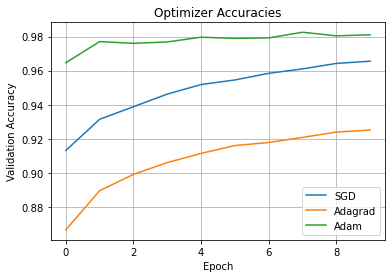

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(history_SGD.history["val_acc"], label="SGD")
plt.plot(history_Adagrad.history["val_acc"], label="Adagrad")
plt.plot(history_Adam.history["val_acc"], label="Adam")
plt.grid(True)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Optimizer Accuracies")
plt.show()

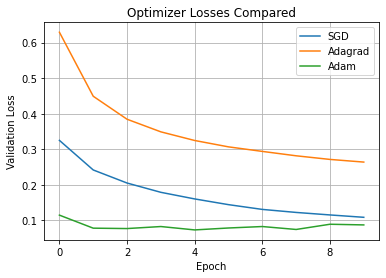

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(history_SGD.history["val_loss"], label="SGD")
plt.plot(history_Adagrad.history["val_loss"], label="Adagrad")
plt.plot(history_Adam.history["val_loss"], label="Adam")
plt.grid(True)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Optimizer Losses Compared")
plt.show()

**Figure: Accuracies of the three optimizers over 10 epochs.** Adam converges faster than either SGD or AdaGrad.

In [32]:
# evaluate model
score_SGD = model_SGD.evaluate(X_test, Y_test, verbose=1)
score_Adagrad = model_Adagrad.evaluate(X_test, Y_test, verbose=1)
score_Adam = model_Adam.evaluate(X_test, Y_test, verbose=1)

print("SGD accuracy:", score_SGD[1])
print("Adagrad accuracy:", score_Adagrad[1])
print("Adam accuracy:", score_Adam[1])

10000/10000 [==============================] - 1s 53us/step
SGD accuracy: 0.965499997138977
Adagrad accuracy: 0.9251000285148621
Adam accuracy: 0.9810000061988831


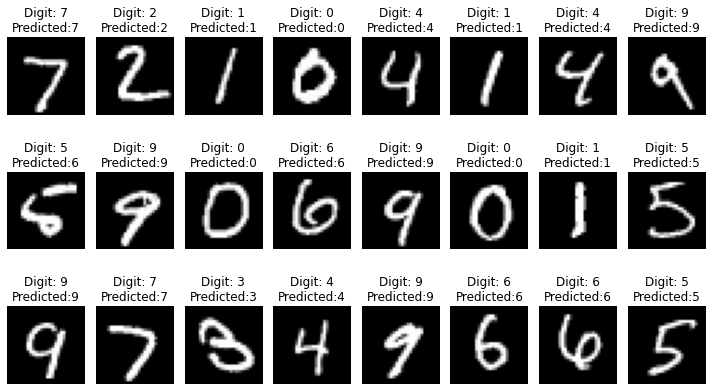

In [33]:
# X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_Adam.predict(X_test)
X_test_0 = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

fig, axes = plt.subplots(3, 8, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_0[i, :, :, 0], cmap="gray")
    ax.title.set_text("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    ax.axis("off")
plt.tight_layout()

**Figure: Losses of the three optimizers over 10 epochs.** Adam converges faster than either SGD or AdaGrad.

# 12.2 Convolutional Neural Network

Use Conv2D, MaxPooling2D, Dropout, but also do not forget Flatten, a standard Dense layer and soft-max. 

### Data

**Figure: Predictions by DCNN.**

In [ ]:
# you will need the following for Convolutional Neural Networks

img_rows, img_cols = 28, 28  # number of pixels
num_classes = 10  # 10 digits

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# as float
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# rescale to max 1
X_train /= 255
X_test /= 255

# change to categorical
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == "channels_first":
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    print("Format A.\n")
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    print("Format B.\n")

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print()
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

### Building

In [40]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Conv2D, Flatten, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == "channels_first":
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print()
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [43]:
def create_CNN(OPT):
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)

    model.add(Conv2D(10, kernel_size=(5, 5), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, kernel_size=(5, 5), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=OPT, metrics=["acc"])
    return model

In [44]:
model_CNN = create_CNN(optimizers.Adam())
model_CNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)          4016      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)             

In [ ]:
plot_model(model, to_file="./CNN.png", show_shapes=True, show_layer_names=False)

### Training

In [ ]:
# TO SAVE TIME
save_model_path='./CNN'
# model_CNN = tf.keras.models.load_model(filepath=save_model_path)

In [45]:
batch_size = 32
N_epochs = 10
history_CNN = model_CNN.fit(
    X_train, Y_train, batch_size=batch_size, epochs=N_epochs, verbose=1, validation_data=(X_test, Y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 59s 984us/step - loss: 0.2775 - acc: 0.9157 - val_loss: 0.0657 - val_acc: 0.9777
Epoch 2/10
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1049 - acc: 0.9696 - val_loss: 0.0442 - val_acc: 0.9852
Epoch 3/10
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0808 - acc: 0.9756 - val_loss: 0.0380 - val_acc: 0.9871
Epoch 4/10
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0649 - acc: 0.9811 - val_loss: 0.0400 - val_acc: 0.9867
Epoch 5/10
60000/60000 [==============================] - 66s 1ms/step - loss: 0.0574 - acc: 0.9829 - val_loss: 0.0455 - val_acc: 0.9857
Epoch 6/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0527 - acc: 0.9842 - val_loss: 0.0371 - val_acc: 0.9885
Epoch 7/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0452 - acc: 0.9864 - val_loss: 0.0305 - val_a

In [48]:
save_model_path='./CNN'
model_CNN.save(filepath=save_model_path)

In [ ]:
batch_size = 32
N_epochs = 10

In [ ]:
# train CNN and store training info in history
history_CNN = model_CNN.fit(
    X_train, Y_train, batch_size=batch_size, epochs=N_epochs, verbose=1, validation_data=(X_test, Y_test)
)

### Evaluation

10000/10000 [==============================] - 4s 372us/step

Test loss: 0.03271747072827093
Test accuracy: 0.9901999831199646


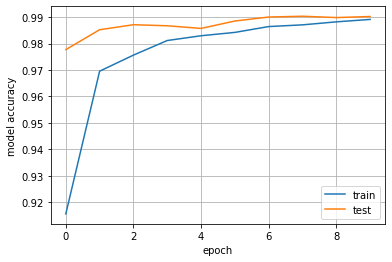

In [49]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# look into training history

# summarize history for accuracy
plt.plot(history_CNN.history["acc"])
plt.plot(history_CNN.history["val_acc"])
plt.ylabel("model accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="best")
plt.grid(True)
plt.show()

# summarize history for loss
# plt.plot(history_CNN.history["loss"])
# plt.plot(history_CNN.history["val_loss"])
# plt.ylabel("model loss")
# plt.xlabel("epoch")
# plt.legend(["train", "test"], loc="best")
# plt.grid(True)
# plt.show()

### Positive Results

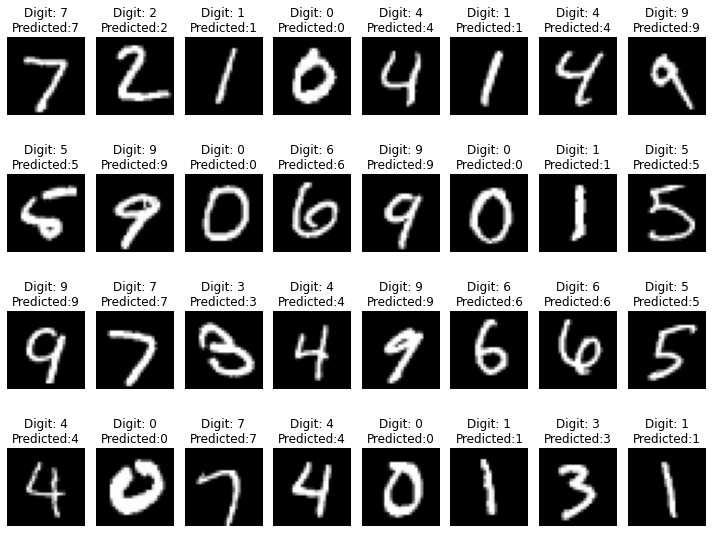

In [50]:
# let's see more of these...
# X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)
X_test_0 = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

fig, axes = plt.subplots(4, 8, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_0[i, :, :, 0], cmap="gray")
    ax.title.set_text("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    ax.axis("off")
plt.tight_layout()

**Figure: Hand-drawn digits and their guesses.** 

### Negative Results

In [51]:
wrong_guess = []
for i, guess in enumerate(predictions):
    if np.argmax(guess) != np.argmax(Y_test[i]):
        wrong_guess.append(i)

print(len(wrong_guess))

98


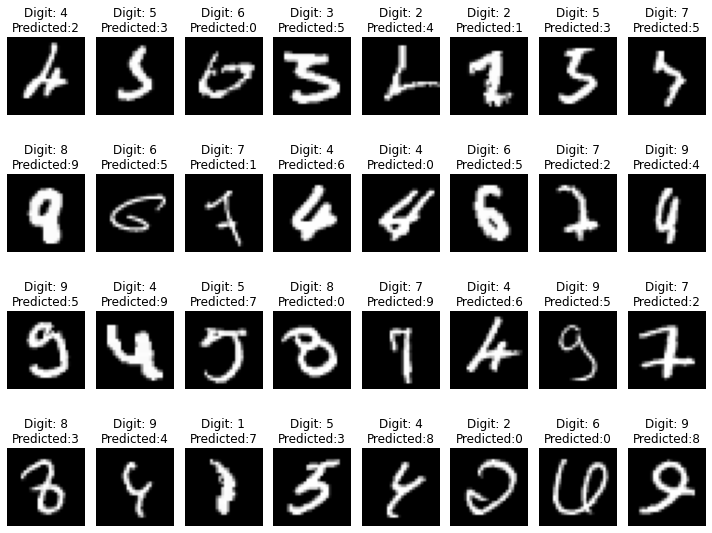

In [52]:
fig, axes = plt.subplots(4, 8, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    j = wrong_guess[i]
    ax.imshow(X_test_0[j, :, :, 0], cmap="gray")
    ax.title.set_text("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[j]), np.argmax(predictions[j])))
    ax.axis("off")
plt.tight_layout()

**Figure: Gallery of some of the misidentified digits.**

# 12.3 Hand-drawn digits using GIMP

In [53]:
digit_dir = "./digits/"
digit_list = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"]

### Version One

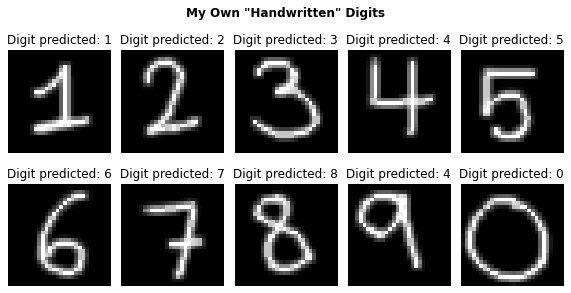

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.flat):

    digit_filename = digit_dir + digit_list[i] + ".png"
    digit_in = Image.open(digit_filename).convert("L")
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]
    data /= 255

    data = data.reshape(1, xdim, ydim, 1)  # input for model
    pred = model_CNN.predict(data)
    data = data.reshape(xdim, ydim)  # back to matrix

    j = wrong_guess[i]
    ax.imshow(data, cmap="gray")
    ax.title.set_text("Digit predicted: {}".format(np.argmax(pred)))
    ax.axis("off")
plt.tight_layout()
plt.suptitle('My Own "Handwritten" Digits', x=0.5, y=1.05, weight="bold")
plt.show()

**Figure: CNN on handwritten digits.** Looks pretty good. I would expect that the accuracy on my own handwriting would be lower than the accuracy on the validation data because my data were generated in different conditions.

### Version Two

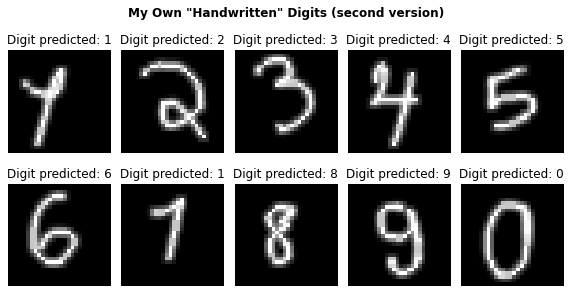

In [55]:
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.flat):

    digit_filename = digit_dir + digit_list[i] + "_b.png"
    digit_in = Image.open(digit_filename).convert("L")
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]
    data /= 255

    data = data.reshape(1, xdim, ydim, 1)  # input for model
    pred = model_CNN.predict(data)
    data = data.reshape(xdim, ydim)  # back to matrix

    j = wrong_guess[i]
    ax.imshow(data, cmap="gray")
    ax.title.set_text("Digit predicted: {}".format(np.argmax(pred)))
    ax.axis("off")
plt.tight_layout()
plt.suptitle('My Own "Handwritten" Digits (second version)', x=0.5, y=1.05, weight="bold")
plt.show()

**Figure: Another example of handwriting.** 

## Unused:

In [56]:
layer_index = 0
for layer in model_CNN.layers:
    print(layer_index, layer.name, layer.input_shape)
    layer_index += 1

0 conv2d_7 (None, 28, 28, 1)
1 max_pooling2d_7 (None, 24, 24, 10)
2 conv2d_8 (None, 12, 12, 10)
3 max_pooling2d_8 (None, 8, 8, 16)
4 flatten_4 (None, 4, 4, 16)
5 dense_25 (None, 256)
6 dropout_10 (None, 100)
7 dense_26 (None, 100)


(5, 5, 1, 10)


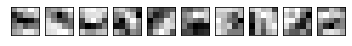

In [57]:
# layer_index should be the index of a convolutional layer
layer_index = 0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap="gray")
    ix += 1
# show the figure
plt.show()

In [58]:
test_index = 0

from keras.models import Model

layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1, 28, 28, 1))


def display_activation(activations, col_size, row_size, layer_index):
    activation = activations[layer_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 3, col_size * 3))
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap="gray")
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:, :, 0], cmap="gray")
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer
plt.show()